In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, ks_2samp, mannwhitneyu
# import seaborn as sns
# from scipy.stats import gaussian_kde
# import numpy as np

In [2]:
df = pd.read_csv("dataset/TRAIN_RELEASE_3SEP2025/train_subtask1.csv")

In [ ]:
import pandas as pd
import numpy as np

# Load the dataset directly (Faster than using the DataLoader)
# Update path if needed
data_path = '"dataset/TRAIN_RELEASE_3SEP2025/train_subtask1.csv"'
print(f"Loading {data_path}...")
df = pd.read_csv(data_path)

print(f"Total Rows: {len(df)}")
print(f"Total Users: {df['user_id'].nunique()}")

# --- 1. FIND USERS WITH < 2 SAMPLES ---
# Correlation requires at least 2 points. If a user has 1 text, they break the metric.
user_counts = df['user_id'].value_counts()
single_text_users = user_counts[user_counts < 2].index.tolist()

if single_text_users:
    print(f"\n⚠️ CRITICAL: Found {len(single_text_users)} users with only 1 text!")
    print(f"   Examples: {single_text_users[:5]}")
    # Fix: You must filter these out before training/val split
else:
    print("\n✅ OK: All users have at least 2 texts.")

# --- 2. FIND USERS WITH ZERO VARIANCE LABELS ---
# These users rated every text exactly the same.
print("\nScanning for Zero-Variance Ground Truth...")
flat_users = []

# Group by user and calculate std dev of targets
user_stats = df.groupby('user_id')[['valence', 'arousal']].std()

# Find users where std is effectively 0 (or NaN if count=1)
broken_valence = user_stats[user_stats['valence'] < 1e-6].index.tolist()
broken_arousal = user_stats[user_stats['arousal'] < 1e-6].index.tolist()

all_broken = set(broken_valence + broken_arousal)

if len(all_broken) > 0:
    print(f"⚠️ FOUND {len(all_broken)} USERS WITH FLAT GROUND TRUTH")
    print("-" * 40)
    
    # Show details for the first 5
    for uid in list(all_broken)[:5]:
        user_data = df[df['user_id'] == uid]
        print(f"User {uid} ({len(user_data)} texts):")
        print(f"  Valence: {user_data['valence'].tolist()}")
        print(f"  Arousal: {user_data['arousal'].tolist()}")
        print("-" * 40)
else:
    print("✅ OK: No users have completely flat ground truth.")

# --- 3. THE FIX ---
if len(all_broken) > 0 or len(single_text_users) > 0:
    print("\n💡 SUGGESTED FIX:")
    print("Add this filtering line to your EmoVADataset class or preprocessing:")
    print("df = df.groupby('user_id').filter(lambda x: len(x) > 1 and x['valence'].std() > 0 and x['arousal'].std() > 0)")

In [3]:
df.head()

,user_id,text_id,text,timestamp,collection_phase,is_words,valence,arousal
0,3,251,I ' ve been feeling just fine . Nice and relax...,2021-06-08 12:26:16,1,False,1.0,1.0
1,3,252,I ' ve been feeling pretty good . This is my l...,2021-06-09 13:41:40,1,False,0.0,1.0
2,3,253,Still feeling sick today and sneezing alot wit...,2021-06-11 15:13:48,1,False,1.0,1.0
3,3,254,I ' m still feeling kinda sickly but I powered...,2021-06-12 12:20:03,1,False,1.0,1.0
4,3,255,I ' m feeling so much better today ! Seems lik...,2021-06-13 14:54:41,1,False,2.0,1.0


In [4]:
df[df["is_words"] == 0]["text"][0]

"I ' ve been feeling just fine . Nice and relaxed .. Im on my days off from work spending time with my daughters at home . I ' m not sure what else to say . I ' m in a good mood ....................................................."

In [5]:
df[df["is_words"] == 1]

,user_id,text_id,text,timestamp,collection_phase,is_words,valence,arousal
7,10,407,"Tired , Exhausted , Calm , Content , Happy",2021-06-09 12:11:03,1,True,-1.0,0.0
8,10,408,"Content , Calm , Sleepy , Lazy , Relaxed",2021-06-10 17:08:20,1,True,2.0,0.0
9,10,409,"Content , Calm , Relaxed , Happy",2021-06-11 12:03:33,1,True,2.0,0.0
10,10,410,"Calm , Content , Happy , Relaxed",2021-06-11 17:18:21,1,True,2.0,1.0
59,17,1037,"Sad , Depressed , Tired , Spent , Dragging",2022-04-28 20:29:00,3,True,-1.0,1.0
...,...,...,...,...,...,...,...,...
2688,87,380,"Sleepy , Hungry , Happy , Relaxed , Bored",2024-11-15 22:37:49,7,True,1.0,1.0
2691,72,4973,"Tired , Stress , Concerned , Happy , Motivated",2024-09-19 12:04:03,7,True,0.0,1.0
2692,72,4974,"Tired , Concerned , Focused , Determined , Lac...",2024-09-24 17:22:36,7,True,-1.0,0.0
2693,72,4975,"Happy , Relaxed , Focused , Full , Inquisitive",2024-09-25 12:08:34,7,True,1.0,2.0


In [6]:
texts_per_author = (
    df.groupby("user_id")
      .size()
      .reset_index(name="num_texts")
)

texts_per_author.head()

,user_id,num_texts
0,1,5
1,2,177
2,3,5
3,4,8
4,6,21


In [7]:
texts_per_author["num_texts"].max(), texts_per_author["num_texts"].min()

(np.int64(206), np.int64(2))

In [8]:
valence, arousal = df["valence"], df["arousal"]

essays_mask, feeling_words_mask = df["is_words"] == False, df["is_words"] == True 

valence_essays = valence[essays_mask]
arousal_essays = arousal[essays_mask]
valence_feeling = valence[feeling_words_mask]
arousal_feeling = arousal[feeling_words_mask]

In [9]:
def plot_va_distribution(data):
    valence, arousal = data["valence"], data["arousal"]
    
    from scipy.stats import gaussian_kde, ks_2samp, mannwhitneyu
    import numpy as np
    
    # Separate data by is_words
    essays_mask = data["is_words"] == False
    feeling_words_mask = data["is_words"] == True
    
    valence_essays = valence[essays_mask]
    arousal_essays = arousal[essays_mask]
    valence_feeling = valence[feeling_words_mask]
    arousal_feeling = arousal[feeling_words_mask]
    
    # Create a larger figure with more subplots (4 rows x 2 columns)
    fig = plt.figure(figsize=(18, 20))
    
    # Row 1: SCATTER PLOTS
    # Essays (left)
    ax1 = plt.subplot(4, 2, 1)
    scatter1 = ax1.scatter(valence_essays, arousal_essays, alpha=0.5, c=arousal_essays, cmap='viridis', s=50)
    ax1.set_xlabel('Valence', fontsize=12)
    ax1.set_ylabel('Arousal', fontsize=12)
    ax1.set_title('Essays: Valence vs Arousal', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.axhline(y=1.0, color='red', linestyle='--', alpha=0.3, linewidth=1)
    ax1.axvline(x=0.0, color='red', linestyle='--', alpha=0.3, linewidth=1)
    plt.colorbar(scatter1, ax=ax1, label='Arousal')
    
    # Feeling Words (right)
    ax2 = plt.subplot(4, 2, 2)
    scatter2 = ax2.scatter(valence_feeling, arousal_feeling, alpha=0.5, c=arousal_feeling, cmap='viridis', s=50)
    ax2.set_xlabel('Valence', fontsize=12)
    ax2.set_ylabel('Arousal', fontsize=12)
    ax2.set_title('Feeling Words: Valence vs Arousal', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.axhline(y=1.0, color='red', linestyle='--', alpha=0.3, linewidth=1)
    ax2.axvline(x=0.0, color='red', linestyle='--', alpha=0.3, linewidth=1)
    plt.colorbar(scatter2, ax=ax2, label='Arousal')
    
    # Row 2: COMBINED OVERLAY PLOTS
    # Combined scatter (left)
    ax3 = plt.subplot(4, 2, 3)
    ax3.scatter(valence_essays, arousal_essays, alpha=0.4, s=50, c='steelblue', label='Essays', edgecolors='black', linewidth=0.5)
    ax3.scatter(valence_feeling, arousal_feeling, alpha=0.4, s=50, c='coral', label='Feeling Words', edgecolors='black', linewidth=0.5)
    ax3.set_xlabel('Valence', fontsize=12)
    ax3.set_ylabel('Arousal', fontsize=12)
    ax3.set_title('Combined: Valence vs Arousal Overlay', fontsize=14, fontweight='bold')
    ax3.grid(True, alpha=0.3)
    ax3.axhline(y=1.0, color='red', linestyle='--', alpha=0.3, linewidth=1)
    ax3.axvline(x=0.0, color='red', linestyle='--', alpha=0.3, linewidth=1)
    ax3.legend(loc='best', fontsize=10)
    
    # Quadrant analysis (right)
    ax4 = plt.subplot(4, 2, 4)
    
    # Calculate quadrant percentages
    def get_quadrant_stats(val, aro):
        val_threshold = val.median()
        aro_threshold = aro.median()
        q1 = ((val >= val_threshold) & (aro >= aro_threshold)).sum()  # High val, High aro
        q2 = ((val < val_threshold) & (aro >= aro_threshold)).sum()   # Low val, High aro
        q3 = ((val < val_threshold) & (aro < aro_threshold)).sum()    # Low val, Low aro
        q4 = ((val >= val_threshold) & (aro < aro_threshold)).sum()   # High val, Low aro
        total = len(val)
        return [q1/total*100, q2/total*100, q3/total*100, q4/total*100]
    
    essays_quads = get_quadrant_stats(valence_essays, arousal_essays)
    feeling_quads = get_quadrant_stats(valence_feeling, arousal_feeling)
    
    x = np.arange(4)
    width = 0.35
    quadrant_labels = ['Q1: High V,\nHigh A', 'Q2: Low V,\nHigh A', 'Q3: Low V,\nLow A', 'Q4: High V,\nLow A']
    
    ax4.bar(x - width/2, essays_quads, width, label='Essays', color='steelblue', alpha=0.8)
    ax4.bar(x + width/2, feeling_quads, width, label='Feeling Words', color='coral', alpha=0.8)
    ax4.set_ylabel('Percentage (%)', fontsize=12)
    ax4.set_title('Quadrant Analysis (by Median Split)', fontsize=14, fontweight='bold')
    ax4.set_xticks(x)
    ax4.set_xticklabels(quadrant_labels, fontsize=9)
    ax4.legend()
    ax4.grid(True, alpha=0.3, axis='y')
    
    # Row 3: KDE CONTOUR PLOTS
    # Essays KDE (left)
    ax5 = plt.subplot(4, 2, 5)
    valid_mask_essays = ~(np.isnan(valence_essays) | np.isnan(arousal_essays))
    valence_essays_clean = valence_essays[valid_mask_essays]
    arousal_essays_clean = arousal_essays[valid_mask_essays]
    
    if len(valence_essays_clean) > 10:
        # Add small jitter to handle discrete values
        valence_jitter = valence_essays_clean + np.random.normal(0, 0.05, len(valence_essays_clean))
        arousal_jitter = arousal_essays_clean + np.random.normal(0, 0.05, len(arousal_essays_clean))
        
        x_min, x_max = valence_essays_clean.min() - 0.5, valence_essays_clean.max() + 0.5
        y_min, y_max = arousal_essays_clean.min() - 0.5, arousal_essays_clean.max() + 0.5
        xx, yy = np.mgrid[x_min:x_max:100j, y_min:y_max:100j]
        
        positions = np.vstack([xx.ravel(), yy.ravel()])
        values = np.vstack([valence_jitter, arousal_jitter])
        kernel = gaussian_kde(values)
        f = np.reshape(kernel(positions).T, xx.shape)
        
        contour1 = ax5.contourf(xx, yy, f, cmap='Blues', levels=15, alpha=0.8)
        ax5.scatter(valence_essays_clean, arousal_essays_clean, alpha=0.3, s=20, c='darkblue')
        ax5.set_xlabel('Valence', fontsize=12)
        ax5.set_ylabel('Arousal', fontsize=12)
        ax5.set_title('Essays: KDE Density Contour', fontsize=14, fontweight='bold')
        ax5.axhline(y=1.0, color='red', linestyle='--', alpha=0.3, linewidth=1)
        ax5.axvline(x=0.0, color='red', linestyle='--', alpha=0.3, linewidth=1)
        plt.colorbar(contour1, ax=ax5, label='Density')
    
    # Feeling Words KDE (right)
    ax6 = plt.subplot(4, 2, 6)
    valid_mask_feeling = ~(np.isnan(valence_feeling) | np.isnan(arousal_feeling))
    valence_feeling_clean = valence_feeling[valid_mask_feeling]
    arousal_feeling_clean = arousal_feeling[valid_mask_feeling]
    
    if len(valence_feeling_clean) > 10:
        # Add small jitter to handle discrete values
        valence_jitter = valence_feeling_clean + np.random.normal(0, 0.05, len(valence_feeling_clean))
        arousal_jitter = arousal_feeling_clean + np.random.normal(0, 0.05, len(arousal_feeling_clean))
        
        x_min, x_max = valence_feeling_clean.min() - 0.5, valence_feeling_clean.max() + 0.5
        y_min, y_max = arousal_feeling_clean.min() - 0.5, arousal_feeling_clean.max() + 0.5
        xx, yy = np.mgrid[x_min:x_max:100j, y_min:y_max:100j]
        
        positions = np.vstack([xx.ravel(), yy.ravel()])
        values = np.vstack([valence_jitter, arousal_jitter])
        kernel = gaussian_kde(values)
        f = np.reshape(kernel(positions).T, xx.shape)
        
        contour2 = ax6.contourf(xx, yy, f, cmap='Reds', levels=15, alpha=0.8)
        ax6.scatter(valence_feeling_clean, arousal_feeling_clean, alpha=0.3, s=20, c='darkred')
        ax6.set_xlabel('Valence', fontsize=12)
        ax6.set_ylabel('Arousal', fontsize=12)
        ax6.set_title('Feeling Words: KDE Density Contour', fontsize=14, fontweight='bold')
        ax6.axhline(y=1.0, color='red', linestyle='--', alpha=0.3, linewidth=1)
        ax6.axvline(x=0.0, color='red', linestyle='--', alpha=0.3, linewidth=1)
        plt.colorbar(contour2, ax=ax6, label='Density')
    
    # Row 4: HISTOGRAMS
    # Valence comparison (left)
    ax7 = plt.subplot(4, 2, 7)
    ax7.hist(valence_essays, bins=20, color='steelblue', alpha=0.6, edgecolor='black', label='Essays')
    ax7.hist(valence_feeling, bins=20, color='coral', alpha=0.6, edgecolor='black', label='Feeling Words')
    ax7.set_xlabel('Valence', fontsize=12)
    ax7.set_ylabel('Frequency', fontsize=12)
    ax7.set_title('Valence Distribution Comparison', fontsize=14, fontweight='bold')
    ax7.axvline(valence_essays.mean(), color='steelblue', linestyle='--', linewidth=2, label=f'Essays Mean: {valence_essays.mean():.2f}')
    ax7.axvline(valence_feeling.mean(), color='coral', linestyle='--', linewidth=2, label=f'Feeling Mean: {valence_feeling.mean():.2f}')
    ax7.legend(fontsize=9)
    ax7.grid(True, alpha=0.3, axis='y')
    
    # Arousal comparison (right)
    ax8 = plt.subplot(4, 2, 8)
    ax8.hist(arousal_essays, bins=20, color='steelblue', alpha=0.6, edgecolor='black', label='Essays')
    ax8.hist(arousal_feeling, bins=20, color='coral', alpha=0.6, edgecolor='black', label='Feeling Words')
    ax8.set_xlabel('Arousal', fontsize=12)
    ax8.set_ylabel('Frequency', fontsize=12)
    ax8.set_title('Arousal Distribution Comparison', fontsize=14, fontweight='bold')
    ax8.axvline(arousal_essays.mean(), color='steelblue', linestyle='--', linewidth=2, label=f'Essays Mean: {arousal_essays.mean():.2f}')
    ax8.axvline(arousal_feeling.mean(), color='coral', linestyle='--', linewidth=2, label=f'Feeling Mean: {arousal_feeling.mean():.2f}')
    ax8.legend(fontsize=9)
    ax8.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    # Statistical Tests
    print("=" * 80)
    print("STATISTICAL ANALYSIS")
    print("=" * 80)
    
    # Kolmogorov-Smirnov test
    ks_valence = ks_2samp(valence_essays, valence_feeling)
    ks_arousal = ks_2samp(arousal_essays, arousal_feeling)
    
    # Mann-Whitney U test (non-parametric)
    mw_valence = mannwhitneyu(valence_essays, valence_feeling, alternative='two-sided')
    mw_arousal = mannwhitneyu(arousal_essays, arousal_feeling, alternative='two-sided')
    
    print("\n1. Kolmogorov-Smirnov Test (Distribution Similarity):")
    print("-" * 80)
    print(f"   Valence: statistic={ks_valence.statistic:.4f}, p-value={ks_valence.pvalue:.4e}")
    print(f"   Arousal: statistic={ks_arousal.statistic:.4f}, p-value={ks_arousal.pvalue:.4e}")
    print(f"   Interpretation: p < 0.05 suggests significantly different distributions")
    
    print("\n2. Mann-Whitney U Test (Median Comparison):")
    print("-" * 80)
    print(f"   Valence: U-statistic={mw_valence.statistic:.2f}, p-value={mw_valence.pvalue:.4e}")
    print(f"   Arousal: U-statistic={mw_arousal.statistic:.2f}, p-value={mw_arousal.pvalue:.4e}")
    print(f"   Interpretation: p < 0.05 suggests significantly different medians")
    
    # Summary statistics
    print("\n3. Summary Statistics:")
    print("=" * 80)
    print(f"\n{'Metric':<25} {'Essays':<25} {'Feeling Words':<25}")
    print("-" * 80)
    print(f"{'Valence Mean:':<25} {valence_essays.mean():<25.3f} {valence_feeling.mean():<25.3f}")
    print(f"{'Valence Median:':<25} {valence_essays.median():<25.3f} {valence_feeling.median():<25.3f}")
    print(f"{'Valence Std:':<25} {valence_essays.std():<25.3f} {valence_feeling.std():<25.3f}")
    print(f"{'Arousal Mean:':<25} {arousal_essays.mean():<25.3f} {arousal_feeling.mean():<25.3f}")
    print(f"{'Arousal Median:':<25} {arousal_essays.median():<25.3f} {arousal_feeling.median():<25.3f}")
    print(f"{'Arousal Std:':<25} {arousal_essays.std():<25.3f} {arousal_feeling.std():<25.3f}")
    print(f"{'Data Points:':<25} {len(valence_essays):<25} {len(valence_feeling):<25}")
    
    # Correlation analysis
    print("\n4. Valence-Arousal Correlation:")
    print("-" * 80)
    corr_essays = np.corrcoef(valence_essays, arousal_essays)[0, 1]
    corr_feeling = np.corrcoef(valence_feeling, arousal_feeling)[0, 1]
    print(f"   Essays: r = {corr_essays:.3f}")
    print(f"   Feeling Words: r = {corr_feeling:.3f}")
    
    print("=" * 80)

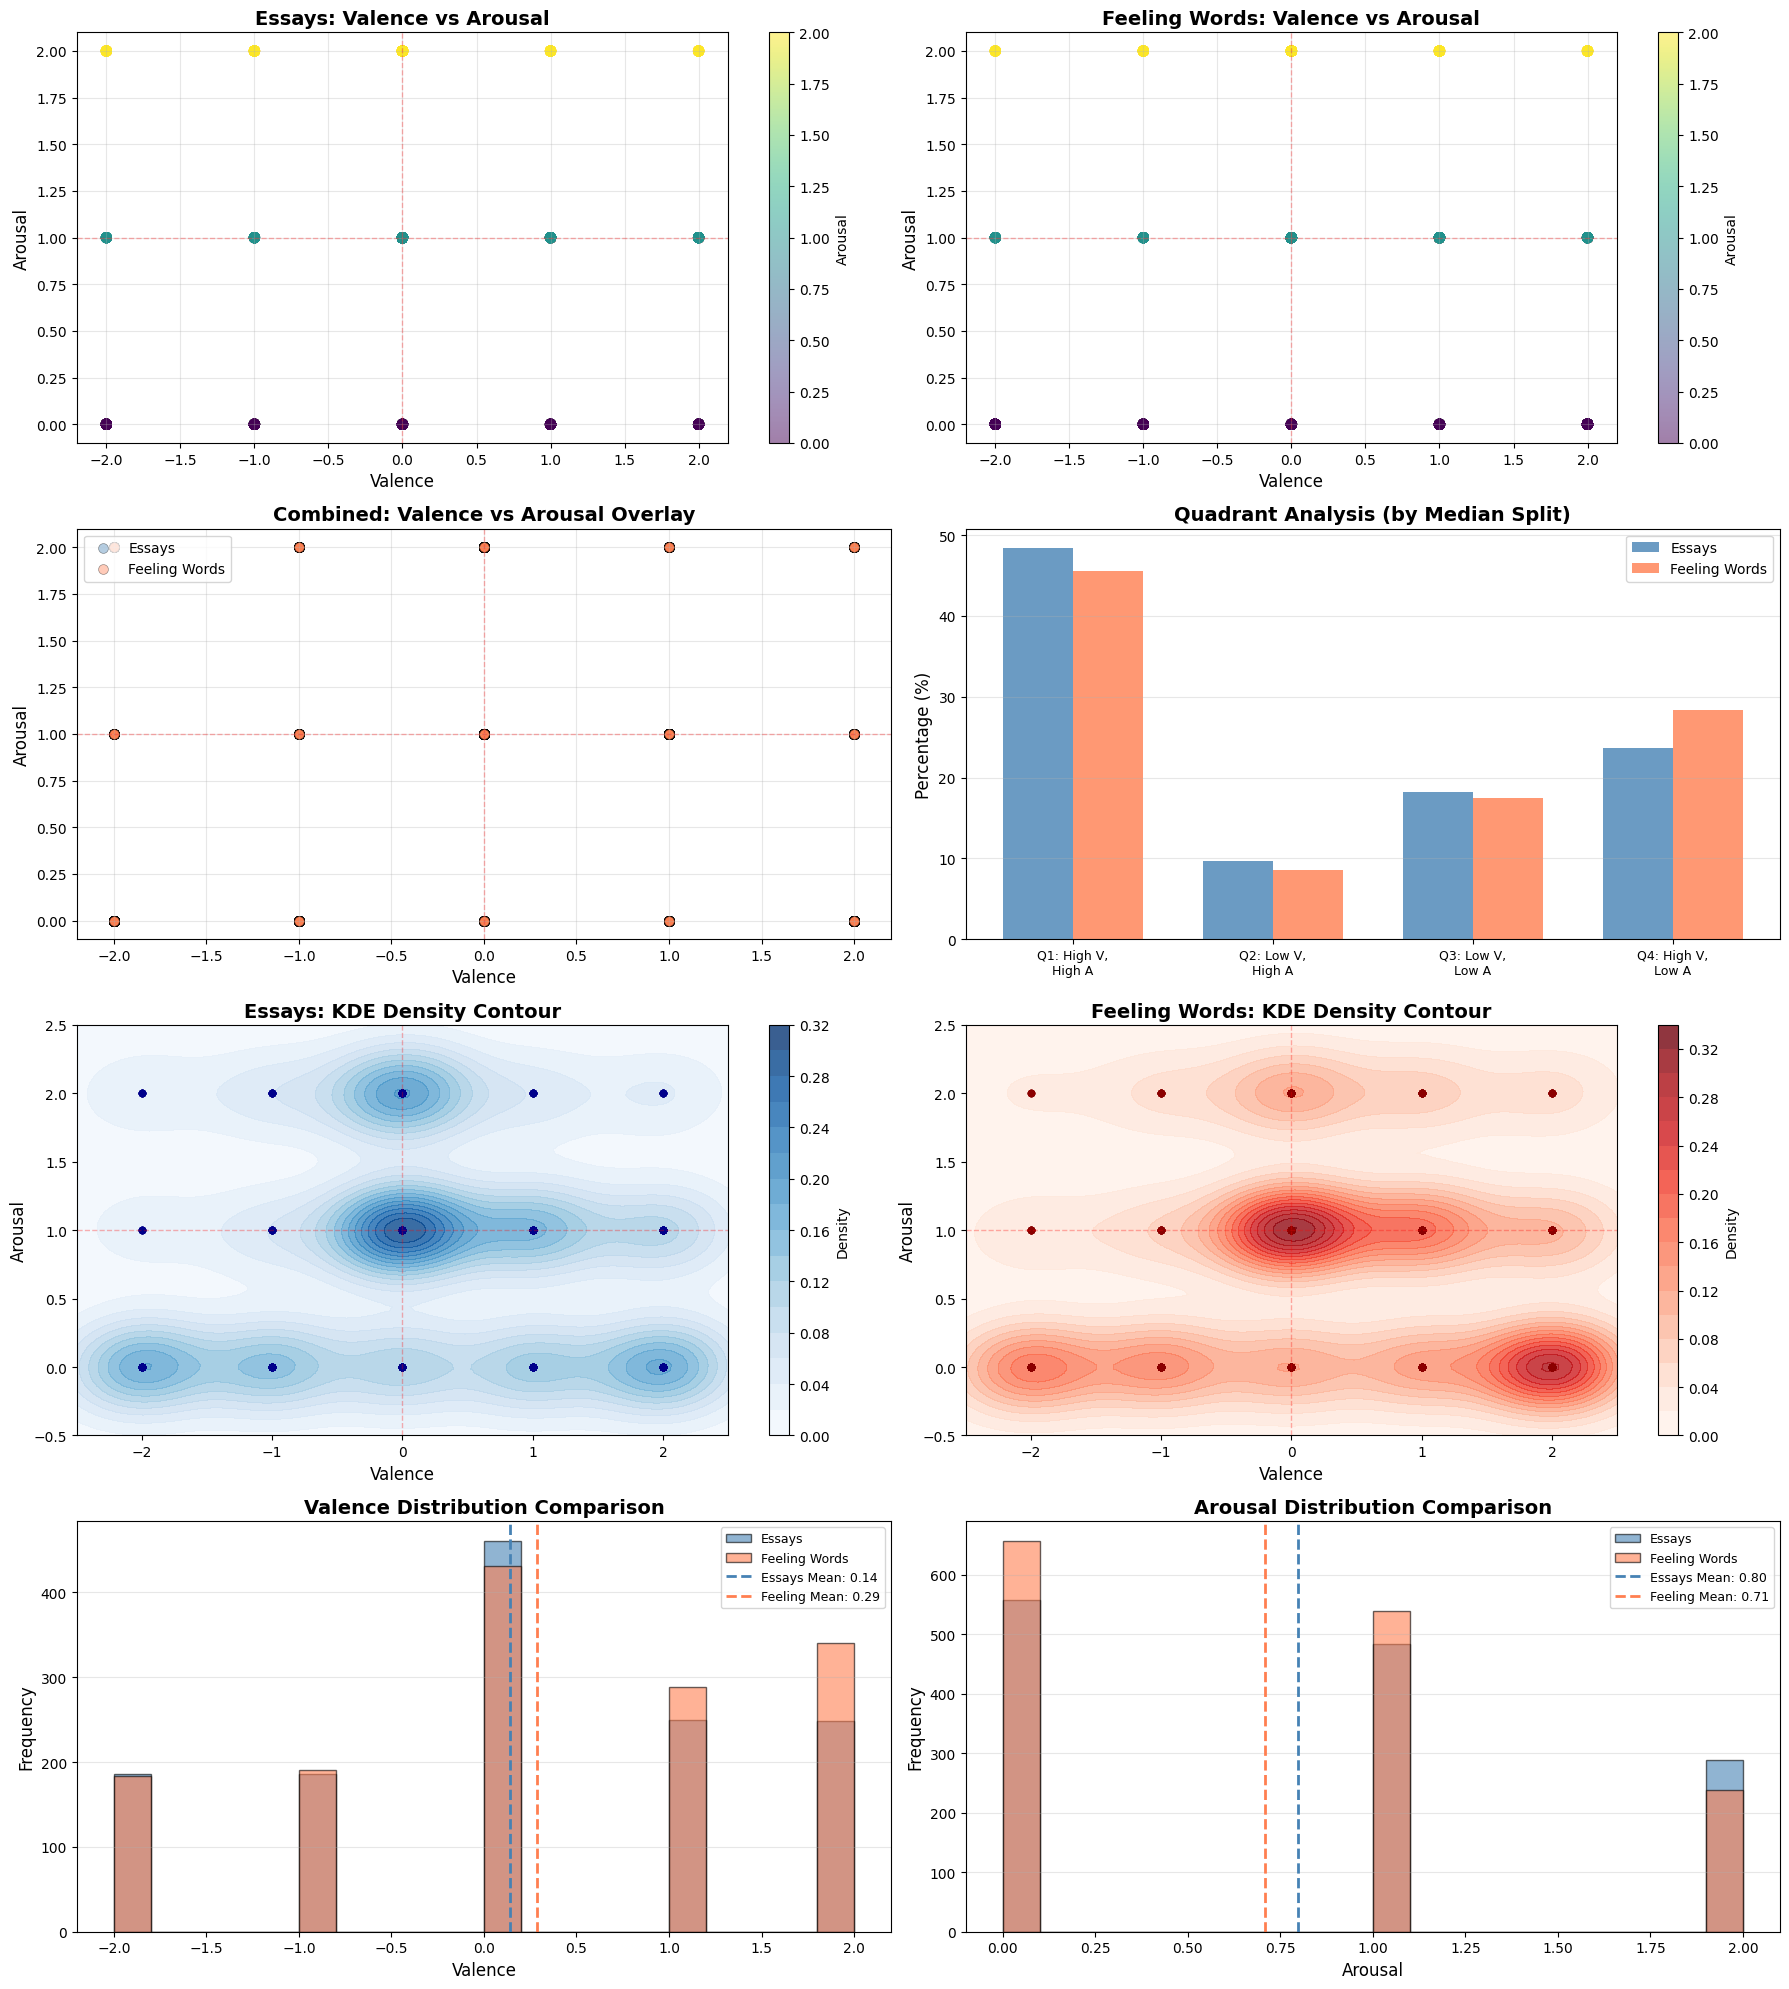

STATISTICAL ANALYSIS

1. Kolmogorov-Smirnov Test (Distribution Similarity):
--------------------------------------------------------------------------------
   Valence: statistic=0.0641, p-value=6.5054e-03
   Arousal: statistic=0.0510, p-value=5.2364e-02
   Interpretation: p < 0.05 suggests significantly different distributions

2. Mann-Whitney U Test (Median Comparison):
--------------------------------------------------------------------------------
   Valence: U-statistic=891053.50, p-value=2.1192e-03
   Arousal: U-statistic=1011233.00, p-value=3.0219e-03
   Interpretation: p < 0.05 suggests significantly different medians

3. Summary Statistics:

Metric                    Essays                    Feeling Words            
--------------------------------------------------------------------------------
Valence Mean:             0.141                     0.287                    
Valence Median:           0.000                     0.000                    
Valence Std:              

In [10]:
plot_va_distribution(df)